In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

In [4]:
import math

class pipe():
    def __init__(self):
        self.left_line_x = []
        self.left_line_y = []
        self.right_line_x = []
        self.right_line_y = []
        
        self.b_predict_left_x1 = 450
        self.b_predict_left_x2 = 150
        self.b_predict_right_x1 = 500
        self.b_predict_right_x2 = 850
        '''
        self.b_predict_left_x1 = 600
        self.b_predict_left_x2 = -460
        self.b_predict_right_x1 = 700
        self.b_predict_right_x2 = 2100
        '''
        
    def grayscale(self, img):
        return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
   
    def canny(self, img, low_threshold, high_threshold):
        return cv2.Canny(img, low_threshold, high_threshold)

    def gaussian_blur(self, img, kernel_size):
        return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

    def region_of_interest(self, img, vertices):
        mask = np.zeros_like(img)   

        if len(img.shape) > 2:
            channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
            ignore_mask_color = (255,) * channel_count
        else:
            ignore_mask_color = 255

        cv2.fillPoly(mask, vertices, ignore_mask_color)

        masked_image = cv2.bitwise_and(img, mask)
        return masked_image

    def draw_lines(self, img, lines, color=[255, 0, 0], thickness=2):
        left_line_x = []
        left_line_y = []
        right_line_x = []
        right_line_y = []
        slope_all = []
        distance_all = []
        t_left_line_x = []
        t_left_line_y = []
        t_right_line_x = []
        t_right_line_y = []

        #somtime wrong input comes..
        for line in lines:
            for x1,y1,x2,y2 in line:
                slope = (y2-y1)/(x2-x1)
                distance = math.sqrt(math.pow(y2-y1,2) + math.pow(x2-x1,2))
                if distance > 300 : continue
                if (y2-y1)*(x2-x1) == 0 : continue
                distance_all.append(distance)
                slope_all.append(slope)
                if slope < 0:
                    left_line_x.append([x1])
                    left_line_x.append([x2])
                    left_line_y.append([y1])
                    left_line_y.append([y2])
                if slope > 0:
                    right_line_x.append([x1])
                    right_line_x.append([x2])
                    right_line_y.append([y1])
                    right_line_y.append([y2])
        

        t_left_line_x = left_line_x + self.left_line_x 
        t_left_line_y = left_line_y + self.left_line_y 
        t_right_line_x = right_line_x + self.right_line_x 
        t_right_line_y = right_line_y + self.right_line_y 
        
        self.left_line_x = []
        self.left_line_y = []
        self.right_line_x = []
        self.right_line_y = []
        self.left_line_x = left_line_x
        self.left_line_y = left_line_y
        self.right_line_x = right_line_x
        self.right_line_y = right_line_y
        
        #debug len
        '''
        print('len(t_left_line_x): {}'.format(len(t_left_line_x)))
        print('len(t_left_line_y): {}'.format(len(t_left_line_y)))
        print('len(t_right_line_x): {}'.format(len(t_right_line_x)))
        print('len(t_right_line_y): {}'.format(len(t_right_line_y)))
        '''
        
        if len(t_left_line_x) == 0:
            print("t_left_line_x no exist")
            return False
        elif len(t_left_line_y) == 0:
            print("t_left_line_y no exist")
            return False
        elif len(t_right_line_x) == 0:
            print("t_right_line_x no exist")
            return False
        elif len(t_right_line_y) == 0:
            print("t_right_line_y no exist")
            return False
        
        from sklearn.linear_model import LinearRegression
        clf1 = LinearRegression()
        clf1.fit(t_left_line_y, t_left_line_x)
        # cv2.line parameters
        # ==>(img, start_position=(x1,y1), end_position=(x2,y2), line_color, thickness)
        y1=330
        y2=539
        #y1=450
        #y2=1280
        
        predict_left_x1 = int(clf1.predict(y1)[0][0])
        predict_left_x2 = int(clf1.predict(y2)[0][0])
        
        diff_left_x1 = abs(self.b_predict_left_x1)-abs(predict_left_x1)
        diff_left_x2 = abs(self.b_predict_left_x2)-abs(predict_left_x2)
        
        if abs(diff_left_x1) > 30:
            predict_left_x1 = self.b_predict_left_x1
        else:
            self.b_predict_left_x1 = predict_left_x1
        if abs(diff_left_x2) > 30:
            predict_left_x2 = self.b_predict_left_x2
        else:
            self.b_predict_left_x2 = predict_left_x2
        
        #print("t_left_line_y:{},t_left_line_x:{},predict_left_x1:{}, predict_left_x2:{}".format(t_left_line_y,t_left_line_x,predict_left_x1,predict_left_x2))
        #print("predict_left_x1:{}, predict_left_x2:{}".format(predict_left_x1,predict_left_x2))
        #print("distance:{}".format(distance_all))
        cv2.line(img,(predict_left_x1,y1),(predict_left_x2,y2),(255,0,0),12)
        
        clf2 = LinearRegression()
        clf2.fit(t_right_line_y, t_right_line_x)
        predict_right_x1 = int(clf2.predict(y1)[0][0])
        predict_right_x2 = int(clf2.predict(y2)[0][0])
        
        '''
        f_right_line_x = [val for sublist in t_right_line_x for val in sublist]   
        if int(min(f_right_line_x)) > predict_right_x1 or int(max(f_right_line_x)) < predict_right_x1 or int(min(f_right_line_x)) > predict_right_x2 or int(max(f_right_line_x)) < predict_right_x2:
            predict_right_x1 = min(f_right_line_x)
            predict_right_x2 = max(f_right_line_x)
        '''
        #debug mode
        #print("t_right_line_y:{},t_right_line_x:{},predict_right_x1:{}, predict_right_x2:{}".format(t_right_line_y,t_right_line_x,predict_right_x1,predict_right_x2))
        #print("predict_right_x1:{}, predict_right_x2:{}".format(predict_right_x1,predict_right_x2))
        
        diff_right_x1 = abs(self.b_predict_right_x1)-abs(predict_right_x1)
        diff_right_x2 = abs(self.b_predict_right_x2)-abs(predict_right_x2)
        
        if abs(diff_right_x1) > 30:
            predict_right_x1 = self.b_predict_right_x1
        else:
            self.b_predict_right_x1 = predict_right_x1
        if abs(diff_right_x2) > 30:
            predict_right_x2 = self.b_predict_right_x2
        else:
            self.b_predict_right_x2 = predict_right_x2
    
        cv2.line(img,(predict_right_x1,y1),(predict_right_x2,y2),(255,0,0),12)
        
    def hough_lines(self, img, rho, theta, threshold, min_line_len, max_line_gap):
        lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
        line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
        self.draw_lines(line_img, lines)
        return line_img

    def weighted_img(self, img, initial_img, α=0.8, β=1., λ=0.):
        return cv2.addWeighted(initial_img, α, img, β, λ)
    
    def process_image(self, image):
        img_gray = self.grayscale(image)
        edges = self.canny(self.gaussian_blur(img_gray,5),50,100)
        imshape = image.shape
        #vertices = np.array([[(180, 650), (650, 450), (730, 450), (1280, 650)]], dtype=np.int32)
        vertices = np.array([[(0, imshape[0]), (450, 330), (490, 330), (imshape[1], imshape[0])]], dtype=np.int32)
        
        masked_image = self.region_of_interest(edges, vertices)

        rho = 2 
        theta = np.pi/180 
        threshold = 15    
        min_line_len = 40 
        max_line_gap = 20    
        line_img = self.hough_lines(masked_image, rho, theta, threshold, min_line_len, max_line_gap)
        result_img = self.weighted_img(line_img, image)
        return result_img
    
    def test_image(self, image):
        img_gray = self.grayscale(image)
        edges = self.canny(self.gaussian_blur(img_gray,5),50,100)
        imshape = image.shape
        #vertices = np.array([[(180, 650), (650, 450), (730, 450), (1280, 650)]], dtype=np.int32)
        vertices = np.array([[(0, imshape[0]), (450, 330), (490, 330), (imshape[1], imshape[0])]], dtype=np.int32)
        
        masked_image = self.region_of_interest(edges, vertices)
        
        rho = 2 
        theta = np.pi/180 
        threshold = 15    
        min_line_len = 40 
        max_line_gap = 20    
        line_img = self.hough_lines(masked_image, rho, theta, threshold, min_line_len, max_line_gap)
        result_img = self.weighted_img(line_img, image)
        return result_img

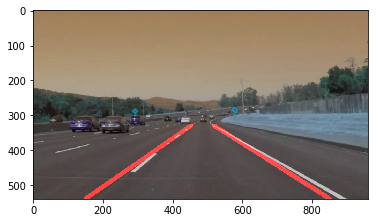

In [6]:
p = pipe()
path = "test_images/"
img = cv2.imread(path+'solidWhiteCurve.jpg')
plt.imshow(p.test_image(img))

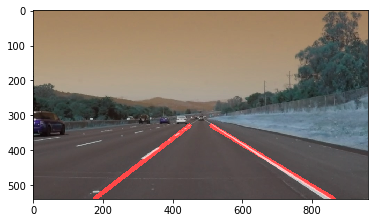

In [7]:
path = "test_images/"
img = cv2.imread(path+'solidWhiteRight.jpg')
plt.imshow(p.test_image(img))

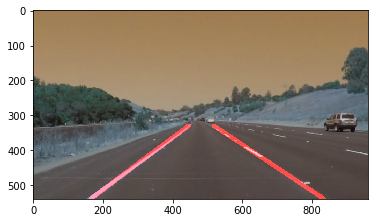

In [8]:
path = "test_images/"
img = cv2.imread(path+'solidYellowCurve.jpg')
plt.imshow(p.test_image(img))

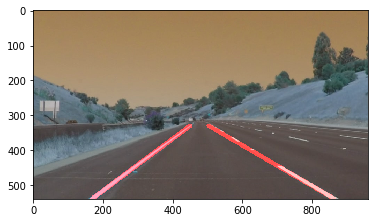

In [9]:
path = "test_images/"
img = cv2.imread(path+'solidYellowCurve2.jpg')
plt.imshow(p.test_image(img))

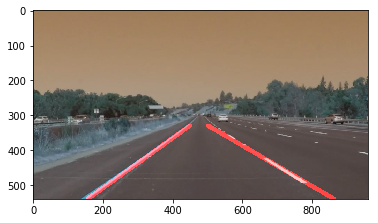

In [10]:
path = "test_images/"
img = cv2.imread(path+'solidYellowLeft.jpg')
plt.imshow(p.test_image(img))

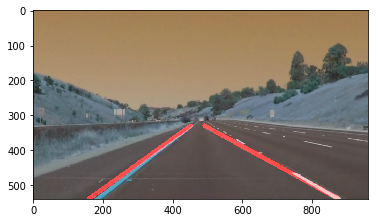

In [11]:
path = "test_images/"
img = cv2.imread(path+'whiteCarLaneSwitch.jpg')
plt.imshow(p.test_image(img))

In [12]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [13]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(p.process_image) 
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:12<00:00, 17.00it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 4.4 s, sys: 640 ms, total: 5.04 s
Wall time: 14.5 s


In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [15]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(p.process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


  2%|▏         | 13/682 [00:00<00:31, 20.92it/s]

t_right_line_x no exist
t_right_line_x no exist


  4%|▎         | 25/682 [00:00<00:23, 28.27it/s]

t_right_line_x no exist


  5%|▌         | 36/682 [00:01<00:22, 28.46it/s]

t_right_line_x no exist
t_right_line_x no exist


  6%|▋         | 44/682 [00:01<00:22, 27.97it/s]

t_right_line_x no exist


  9%|▊         | 58/682 [00:02<00:46, 13.51it/s]

t_right_line_x no exist


 11%|█         | 72/682 [00:03<00:41, 14.56it/s]

t_right_line_x no exist


 12%|█▏        | 84/682 [00:04<00:40, 14.77it/s]

t_right_line_x no exist


 16%|█▌        | 110/682 [00:06<00:38, 14.69it/s]

t_right_line_x no exist
t_right_line_x no exist


 18%|█▊        | 123/682 [00:07<00:36, 15.12it/s]

t_right_line_x no exist


 20%|█▉        | 135/682 [00:08<00:35, 15.58it/s]

t_right_line_x no exist
t_right_line_x no exist


 21%|██▏       | 145/682 [00:08<00:39, 13.55it/s]

t_right_line_x no exist
t_right_line_x no exist


 23%|██▎       | 159/682 [00:09<00:45, 11.59it/s]

t_right_line_x no exist


 25%|██▍       | 169/682 [00:10<00:42, 12.06it/s]

t_right_line_x no exist
t_right_line_x no exist


 27%|██▋       | 183/682 [00:12<00:49, 10.16it/s]

t_right_line_x no exist


 29%|██▉       | 197/682 [00:13<00:36, 13.21it/s]

t_right_line_x no exist


 31%|███       | 209/682 [00:14<00:31, 15.02it/s]

t_right_line_x no exist


 33%|███▎      | 222/682 [00:15<00:32, 13.94it/s]

t_right_line_x no exist


 34%|███▍      | 233/682 [00:15<00:28, 15.57it/s]

t_right_line_x no exist


 36%|███▌      | 246/682 [00:16<00:29, 14.72it/s]

t_right_line_x no exist
t_right_line_x no exist


 38%|███▊      | 262/682 [00:17<00:27, 15.02it/s]

t_right_line_x no exist


 40%|███▉      | 271/682 [00:18<00:27, 14.88it/s]

t_right_line_x no exist
t_right_line_x no exist


 46%|████▌     | 311/682 [00:20<00:22, 16.62it/s]

t_right_line_x no exist


 47%|████▋     | 322/682 [00:21<00:24, 14.75it/s]

t_right_line_x no exist


 51%|█████     | 347/682 [00:23<00:22, 14.99it/s]

t_right_line_x no exist


 53%|█████▎    | 359/682 [00:23<00:22, 14.61it/s]

t_right_line_x no exist


 56%|█████▌    | 383/682 [00:25<00:19, 14.95it/s]

t_right_line_x no exist
t_right_line_x no exist


 67%|██████▋   | 457/682 [00:30<00:16, 13.88it/s]

t_right_line_x no exist
t_right_line_x no exist


 69%|██████▉   | 469/682 [00:31<00:13, 15.42it/s]

t_right_line_x no exist
t_right_line_x no exist


 71%|███████   | 483/682 [00:32<00:17, 11.11it/s]

t_right_line_x no exist


 74%|███████▍  | 506/682 [00:34<00:11, 15.58it/s]

t_right_line_x no exist


 76%|███████▌  | 520/682 [00:35<00:10, 15.85it/s]

t_right_line_x no exist


 78%|███████▊  | 532/682 [00:35<00:09, 16.16it/s]

t_right_line_x no exist


 80%|███████▉  | 544/682 [00:36<00:08, 15.74it/s]

t_right_line_x no exist


 82%|████████▏ | 556/682 [00:37<00:08, 15.01it/s]

t_right_line_x no exist
t_right_line_x no exist


 83%|████████▎ | 568/682 [00:38<00:07, 15.07it/s]

t_right_line_x no exist
t_right_line_x no exist


 85%|████████▌ | 580/682 [00:38<00:06, 16.29it/s]

t_right_line_x no exist


 87%|████████▋ | 592/682 [00:39<00:06, 14.66it/s]

t_right_line_x no exist


 89%|████████▊ | 604/682 [00:40<00:04, 16.80it/s]

t_right_line_x no exist
t_right_line_x no exist


 91%|█████████ | 618/682 [00:41<00:03, 16.31it/s]

t_right_line_x no exist


 92%|█████████▏| 630/682 [00:42<00:03, 14.59it/s]

t_right_line_x no exist
t_right_line_x no exist


 96%|█████████▌| 654/682 [00:43<00:01, 14.09it/s]

t_right_line_x no exist


 98%|█████████▊| 669/682 [00:44<00:00, 15.96it/s]

t_right_line_x no exist


100%|█████████▉| 679/682 [00:45<00:00, 15.33it/s]

t_right_line_x no exist


100%|█████████▉| 681/682 [00:45<00:00, 14.97it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 14.6 s, sys: 2.06 s, total: 16.6 s
Wall time: 47.4 s


In [16]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))